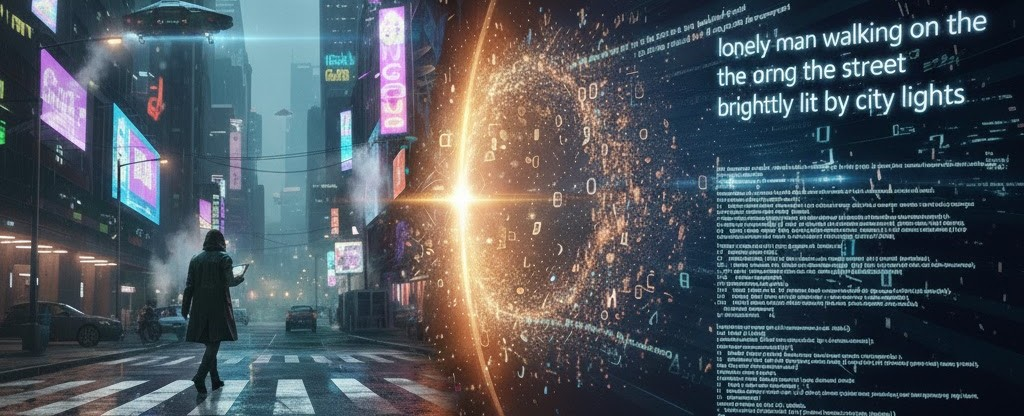

# Problem Statement

**Image captioning**

Image captioning is crucial because it bridges the gap between visual data and human language, allowing machines to understand and describe the content of an image.

It's importance lies in key applications:

- Accessibility: Providing alt-text descriptions for the visually impaired.

- Search & Indexing: Improving the ability of search engines to find images based on their semantic content.

- Robotics: Providing necessary situational awareness for autonomous systems.

**The Flickr8k Dataset**

The Flickr8k Dataset is a foundational benchmark for image captioning models.

- Content: 8,000 images, specifically chosen to show human actions and interactions.

- Annotations: Each image is paired with five distinct human-generated captions, totaling 40,000 captions.

- Purpose: It is used to train and evaluate Encoder-Decoder models (like the CNN-Transformer hybrid) that generate natural language descriptions from visual input.

In [1]:
!rm -rf /kaggle/working/*

In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(2025)
np.random.seed(2025)

2025-12-08 06:09:46.469378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765174186.667107      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765174186.717672      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Key Model Settings

In [4]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Data Preparation

**1. Caption Loading and Filtering**
he process begins by reading the raw caption file (Flickr8k.token.txt) and structuring the data.
- Extraction & Mapping: Each line is read, and the image name and its corresponding caption are separated. The unique image name is cleaned (removing suffixes like #0, #1, etc.) and mapped to its full file path.
- Quality Filtering: Captions are checked for length: any caption that is too short (less than 5 tokens) or too long (greater than SEQ_LENGTH) is discarded. If even one caption for an image is filtered out, that image and all its captions are removed entirely (images_to_skip). This ensures all remaining images have high-quality, valid-length captions.
- Special Token Addition: Valid captions are augmented with start (<start>) and end (<end>) tokens, which signal the beginning and end of a sentence to the language model during training.
- Output: The function returns a caption_mapping (image path $\to$ list of 5 validated captions) and a list of all validated captions (text_data).

**2. Dataset Splitting**

The clean, filtered image-caption mapping is divided into separate sets for Training Data (80%) and Validation Data (20%).

## Captions Pre-Processing

In [5]:

def load_captions_data(filename):

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


## Function to Display Sample

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

def show_random_images_with_ground_truth_captions(num_images_to_display, captions_data_map):
    """Randomly selects and displays images with their ground truth captions directly."""
    all_image_paths = list(captions_data_map.keys())

    # Select unique random image paths
    selected_image_paths = np.random.choice(
        all_image_paths, size=num_images_to_display, replace=False
    )

    DISPLAY_IMAGE_SIZE = (299, 299)

    for img_path in selected_image_paths:
        img_raw = tf.io.read_file(img_path)
        img_decoded = tf.image.decode_jpeg(img_raw, channels=3)
        img_resized_for_display = tf.image.resize(img_decoded, DISPLAY_IMAGE_SIZE)

        img_np = img_resized_for_display.numpy().astype(np.uint8)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_np)
        image_filename = os.path.basename(img_path)
        plt.title(f"Image: {image_filename}")
        plt.axis("off")
        plt.show()

        print("Ground Truth Captions:")
        for i, caption in enumerate(captions_data_map[img_path]):
            print(f"  {i+1}. {caption}")
        print("\n" + "-"*50 + "\n")

In [7]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


I0000 00:00:1765174205.649431      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

# Exploratory Data Analysis (EDA)

Taking a look at the captions file:

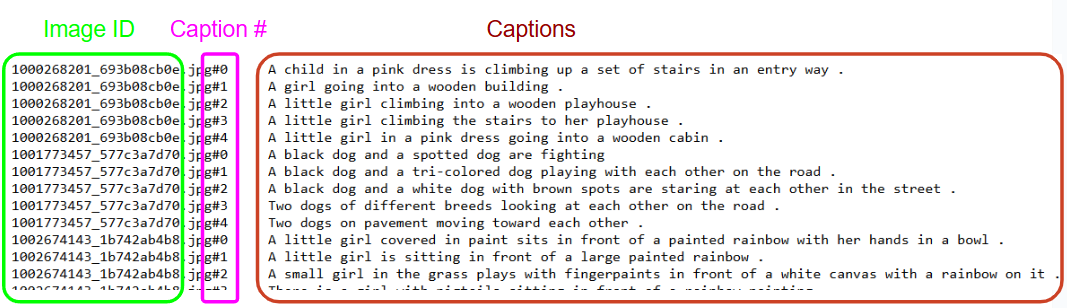

The entire corpus of captions contains approximately 12,000 unique words.

Following the vocabulary analysis, representative samples consisting of images paired with their corresponding captions are displayed to provide a qualitative assessment of the data.

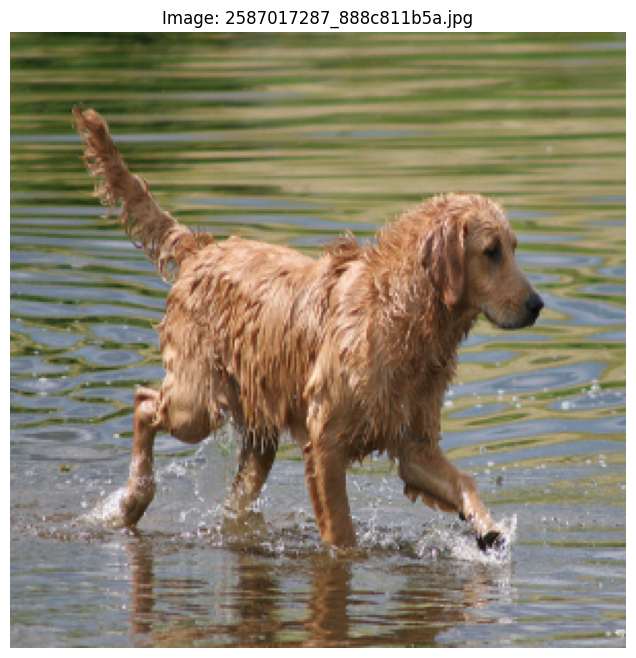

Ground Truth Captions:
  1. <start> A big tan wet dog in shallow water . <end>
  2. <start> A brown dog gets wet in the water . <end>
  3. <start> A brown dog walks through natural water . <end>
  4. <start> A soaking wet dog walks across a stream . <end>
  5. <start> a wet golden retriever is walking through a lake <end>

--------------------------------------------------



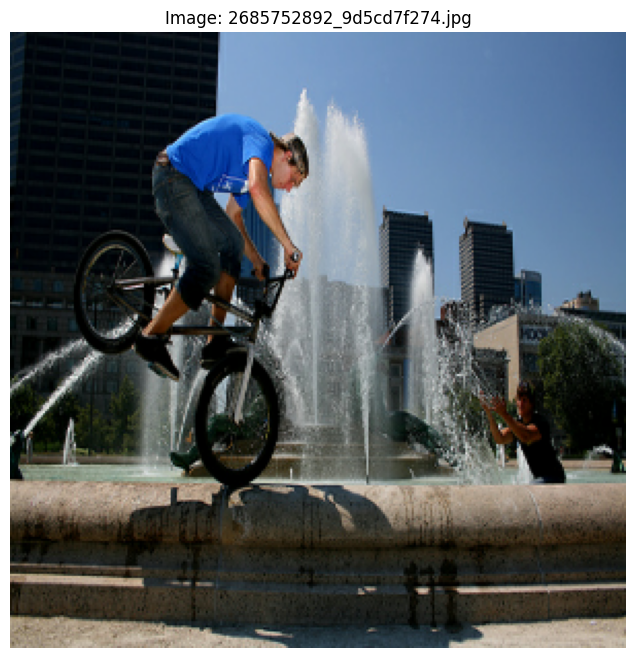

Ground Truth Captions:
  1. <start> A boy on a bicycle rides the ledge of water fountain while another boy is in the fountain . <end>
  2. <start> A man on a bike tries to do a trick on the railing of an outdoor fountain . <end>
  3. <start> a man wearing a blue shirt and hat jumping on one wheel on a fountain ledge <end>
  4. <start> A young man on a bike balances one wheel on the edge of a fountain in a city park . <end>
  5. <start> The guy on his bike does a jump near a water fountain . <end>

--------------------------------------------------



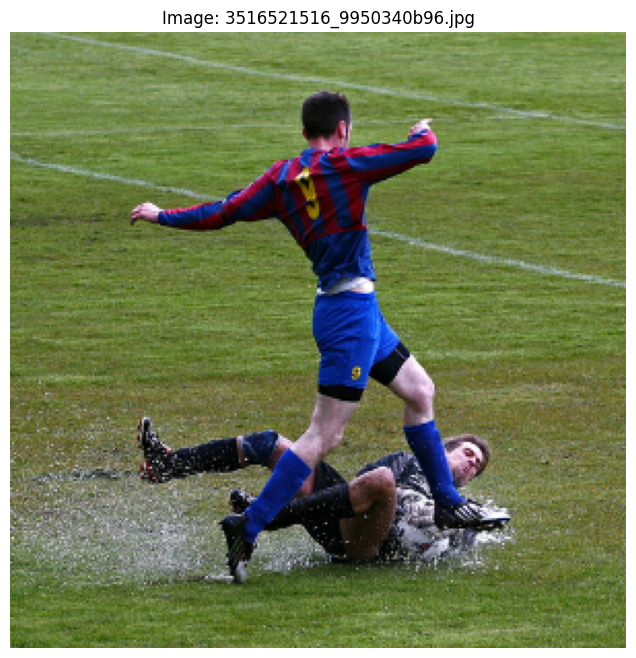

Ground Truth Captions:
  1. <start> A soccer player kicking toward the ball with another player on the soaked ground . <end>
  2. <start> Two men playing rugby collide . <end>
  3. <start> two men playing soccer on a wet field <end>
  4. <start> Two men playing soccer , one on the ground holding the ball . <end>
  5. <start> Two players are on a wet field and one is on the ground . <end>

--------------------------------------------------



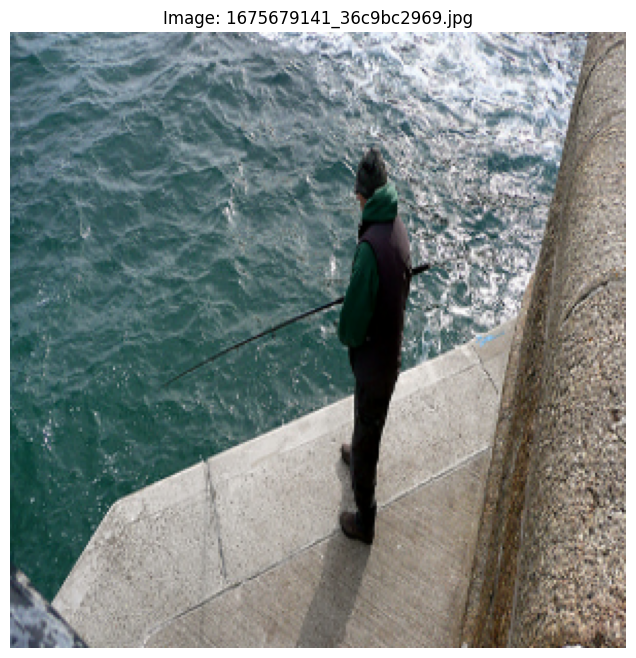

Ground Truth Captions:
  1. <start> A jacketed man with his back to the camera is overlooking the water . <end>
  2. <start> A man fishing from the shore in the wintertime . <end>
  3. <start> A man in a heavy coat fishes from a concrete platform . <end>
  4. <start> A man stands on a concrete ledge and casts his fishing pole into the water below . <end>
  5. <start> A person in warm clothing fishes off a wall . <end>

--------------------------------------------------



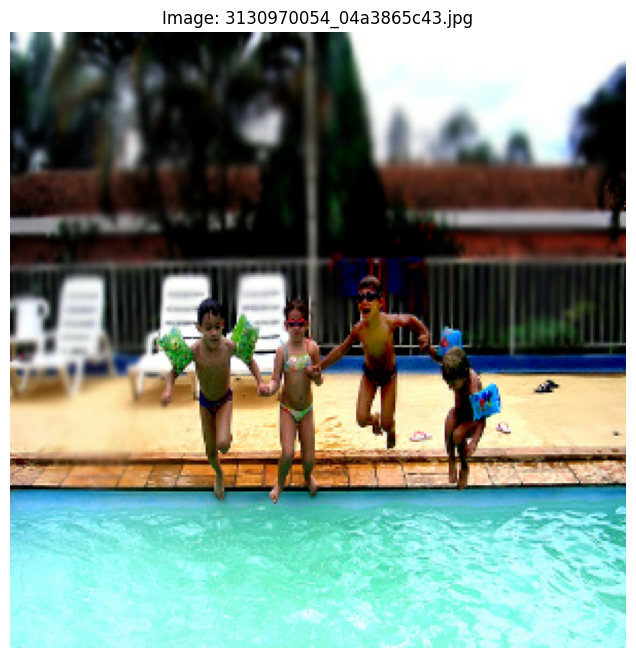

Ground Truth Captions:
  1. <start> Four children hold hands and jump into a pool . <end>
  2. <start> Four children jumping in a swimming pool , with only two wearing water wings . <end>
  3. <start> four children jump into the pool . <end>
  4. <start> Four children jump into the pool together . <end>
  5. <start> Four kids holding hands jump into a swimming pool . <end>

--------------------------------------------------



In [ ]:
show_random_images_with_ground_truth_captions(5, captions_mapping)

# Model Architecture
The system is built on three key, sequential components:

**1. The Vision Encoder (CNN)**
- Transfer Learning: Uses a specialized pre-trained image processing network (EfficientNetB0).

- Role: Acts as a feature extractor. It analyzes the input image and extracts the essential visual data (objects, scenes, etc.).

- Key Detail: The CNN's weights are frozen, meaning it's used only for feature extraction and doesn't require further training, saving significant time and compute resources. The output is reshaped into a sequence of "visual tokens."

**2. The Transformer Encoder (Contextualizer)**
- Component: A specialized Transformer Encoder Block (TransformerEncoderBlock).

- Role: Contextualizes the visual features. It runs an attention mechanism (Self-Attention) over the visual tokens to determine the relationship and importance of different image areas.

- Analogy: This is like the model summarizing the visual hierarchy before writing a sentence.

**3. The Transformer Decoder (Caption Generator)**
- Component: A Transformer Decoder Block (TransformerDecoderBlock).

- Role: Generates the text caption word-by-word. It uses the visual context from the Encoder to inform its language output.

- Key Detail: It employs Cross-Attention to directly link the text being written (the language stream) back to the most relevant parts of the image (the visual stream) at every step. This ensures high descriptive accuracy.

- Output: The final layer predicts the most probable next word until the caption is complete.

**Training Process**

The model is trained using an efficient method that leverages multiple human captions per image:

- The image is analyzed by the frozen CNN.

- The visual features are processed by the Transformer Encoder.

- The model iterates through all five human captions provided for each image.

- For each caption, the Transformer Decoder tries to predict the next word in the sequence.

- Only the weights of the Transformer Encoder and Decoder are updated to minimize the prediction error, while the CNN remains static. This focuses the training effort entirely on the translation of visual context into language.

In [10]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model training

The base model was configured to train for a maximum of 30 epochs. To prevent overfitting and optimize training time, an early stopping mechanism was implemented. This mechanism was set up to monitor the progress and terminate training if no improvement in the validation metric was observed after 7 consecutive epochs.

In [11]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
history_train = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30


I0000 00:00:1765174250.303251      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


96/96 ━━━━━━━━━━━━━━━━━━━━ 107s 706ms/step - acc: 0.1347 - loss: 35.2349 - val_acc: 0.3149 - val_loss: 20.4260
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - acc: 0.3212 - loss: 19.8641 - val_acc: 0.3543 - val_loss: 17.9545
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 632ms/step - acc: 0.3565 - loss: 17.6386 - val_acc: 0.3709 - val_loss: 16.8932
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 636ms/step - acc: 0.3754 - loss: 16.4457 - val_acc: 0.3840 - val_loss: 16.2248
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 632ms/step - acc: 0.3919 - loss: 15.5832 - val_acc: 0.3929 - val_loss: 15.8206
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 632ms/step - acc: 0.4045 - loss: 14.9215 - val_acc: 0.3970 - val_loss: 15.5000
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - acc: 0.4141 - loss: 14.3572 - val_acc: 0.4026 - val_loss: 15.3332
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 632ms/step - acc: 0.4246 - loss: 13.8854 - val_acc: 0.4070 - val_loss: 15.1945
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 

# Model Performance
**1. The Onset of Overfitting**

- Observation: Training loss decreases monotonically (smoothly down), while Validation loss starts to creep up after the 7th epoch.

- Meaning: The model is becoming too specialized in the training data. It continues to find ways to reduce error on the data it has seen, but these adjustments are not helpful—and are, in fact, detrimental—to its ability to generalize to unseen data (the validation set). The rising validation loss is the definitive sign that the model has begun to learn the noise and idiosyncrasies of the training set rather than the underlying patterns.

**2. Learning Rate Schedule Ineffectiveness**

- Observation: A steady decline in the learning rate was scheduled.

- Meaning: While reducing the learning rate often helps the model settle into a good minimum, the rapid onset of overfitting (before the 7th epoch) suggests the model has likely passed the optimal generalization point before the scheduled decline could truly kick in and help. The learning rate schedule alone isn't sufficient to prevent this rapid specialization.

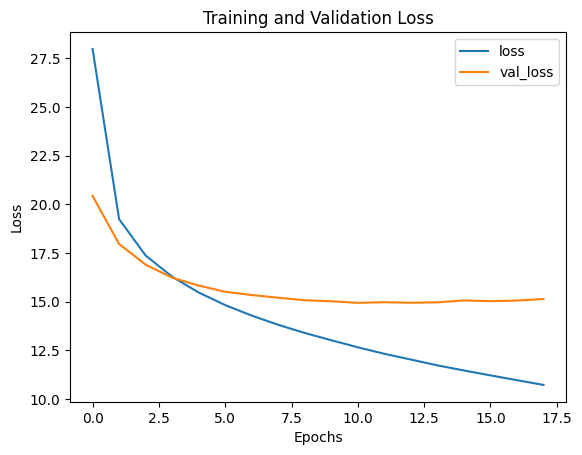

In [12]:
plt.plot(history_train.history["loss"], label="loss")
plt.plot(history_train.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Generated Caption Quality
The quality of the generated captions is mixed, highlighting both strengths in simple recognition and major weaknesses in complex reasoning.

- **Success (Image 1 - Surfer)**: The description ("a surfer in a blue wetsuit is riding a wave") is concise and accurate. This indicates the model has successfully learned common, high-frequency visual-action patterns from the training set.

- **Almost Success (Image 3 - Beach Scene)**: The caption captures the primary subject and activity ("a woman in a bikini top and shorts is walking on the beach") but misses the crucial detail that the woman walks her dog on a leash. This demonstrates a failure to adequately prioritize secondary objects and contextual relationships.

- **Failure (Image 2 - Bizarre Couple)**: The generated caption ("a woman with a green shirt and sunglasses smiles") is largely incorrect, missing the core context and hallucinating details that are not present. There are no "green shirt" or "sunglasses" on the image. This strongly suggests the image represents an Out-of-Distribution (OOD) sample that the model cannot robustly recognize, forcing it to default to a generic, incorrect description based on weak language priors.

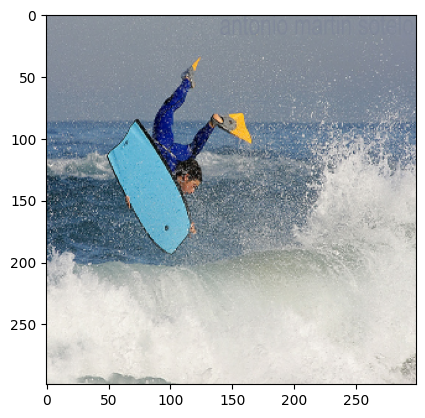

Predicted Caption:  a surfer in a blue wetsuit is riding a wave


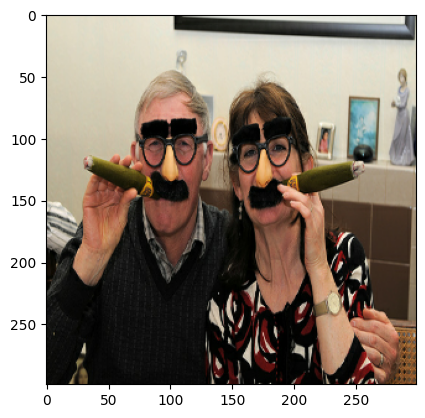

Predicted Caption:  a woman with a green shirt and sunglasses smiles


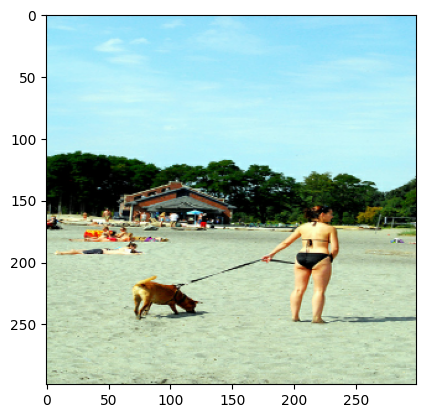

Predicted Caption:  a woman in a bikini top and shorts is walking on the beach


In [13]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(i, model):
    # Select a random image from the validation dataset
    sample_img = valid_images[i]

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption(1, caption_model)
generate_caption(2, caption_model)
generate_caption(3, caption_model)

# Hyperparameter Tuning
The initial model performance was analyzed using two key indicators:

- Loss Function Evolution: The convergence of the loss function suggested that the model may not be capturing the full complexity of the training data.

- Qualitative Caption Analysis: Review of captions generated for test samples indicated a lack of descriptive detail and an inability to capture multiple, distinct elements present within a single scene.

These observations collectively suggested that the model's architecture lacked sufficient complexity.

**Tuning Action: Increasing Attention Heads**

To address the issues described above, a targeted hyperparameter adjustment was implemented based on established literature for Transformer-based models. The primary action taken was to increase the number of attention heads within both the Transformer Encoder and Transformer Decoder blocks.

This increase is a direct method for enhancing the model's capacity to simultaneously focus on diverse features and complex relationships across the input image and sequential caption tokens. Specifically, the number of attention heads was adjusted as follows:

- Transformer Encoder Block: Increased from 1 head to 4 heads.

- Transformer Decoder Block: Increased from 2 heads to 8 heads.

In [14]:
encoder2 = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=4)
decoder2 = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=8)
caption_model2 = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder2,
    decoder=decoder2,
    image_aug=image_augmentation,
)

In [15]:
# Compile the model
caption_model2.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
history_train2 = caption_model2.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.1485 - loss: 34.5929 - val_acc: 0.3258 - val_loss: 19.9580
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.3332 - loss: 19.4258 - val_acc: 0.3648 - val_loss: 17.6077
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.3672 - loss: 17.2320 - val_acc: 0.3809 - val_loss: 16.5335
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.3884 - loss: 16.0057 - val_acc: 0.3928 - val_loss: 15.8906
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.4072 - loss: 15.0694 - val_acc: 0.4012 - val_loss: 15.5405
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.4219 - loss: 14.3642 - val_acc: 0.4084 - val_loss: 15.2016
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.4335 - loss: 13.7717 - val_acc: 0.4120 - val_loss: 15.0534
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.4470 - loss: 13.1918 - val_acc: 0.4161 - val_loss: 14.9489
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/st

# Adjusted Model Performance

**Training Efficiency**

Increasing the complexity of the Transformer architecture resulted in a significant increase in training time. The adjusted model required approximately 60 minutes to train, which is double the time required for the base model (approximately 30 minutes).

**Quantitative Results (Loss Evolution)**

The increased complexity yielded only a marginal improvement in the validation loss compared to the base model, suggesting the hyperparameter tuning did not significantly resolve the core issue causing the loss curve shape.

The loss curves followed a similar pattern to the base model:

- Validation Loss: Reached a minimum point around epochs 7–8 and subsequently began to increase, indicating that the model continued to exhibit signs of overfitting to the training data.

- Test Loss: Continued to decrease throughout training, and at a rate even sharper than that observed in the base model.

**Qualitative Caption Analysis**
Despite the sharp decrease in test loss, a qualitative assessment of the generated captions suggests a degradation in performance. This indicates a potential discrepancy between the optimized loss metric and human-perceived caption quality (i.e., the model is learning to minimize the loss function but not necessarily generating semantically accurate captions).

- Image 1 (Surfer):	"a man is surfing a yellow surfboard"	Inaccurate Attribute: Falsely described the surfboard color, an error the base model did not make.
- Image 2 (Bizzare Couple):	"a man with a mohawk and glasses is holding a cup"	Major Hallucination: Generated multiple inaccurate objects/attributes ("mohawk," "cup"), failing to capture the core elements of the scene.
- Image 3 (Beach Scene): "a man and a dog are standing on a beach"	Improved Multi-Object Detection (Positive): Successfully identified multiple distinct objects ("man" and "dog"). Gender Misclassification (Deficiency): Incorrectly labeled a female subject as "a man."

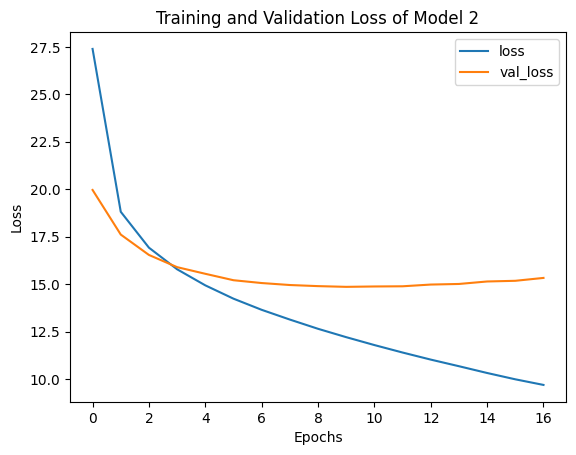

In [16]:
plt.plot(history_train2.history["loss"], label="loss")
plt.plot(history_train2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of Model 2")
plt.legend()
plt.show()

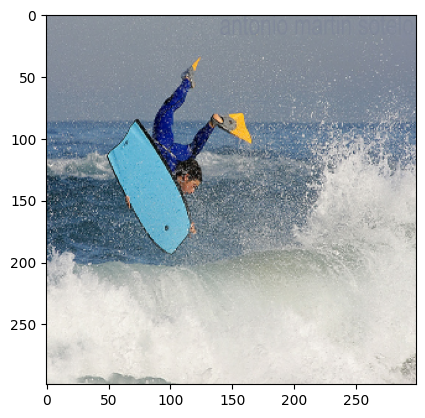

Predicted Caption:  a man is surfing a yellow surfboard


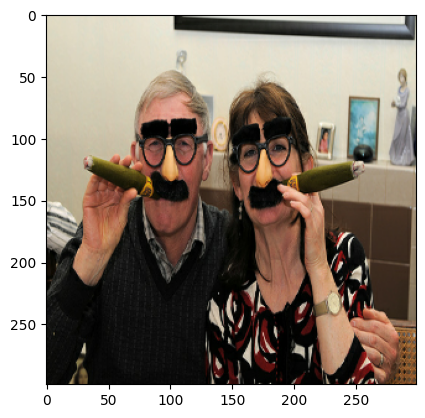

Predicted Caption:  a man with a mohawk and glasses is holding a cup


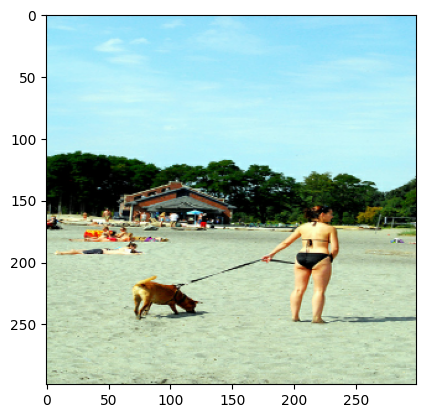

Predicted Caption:  a man and a dog are standing on a beach


In [17]:
generate_caption(1, caption_model2)
generate_caption(2, caption_model2)
generate_caption(3, caption_model2)

# References:

https://keras.io/examples/vision/image_captioning/

https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853/

https://medium.com/data-science/complete-architectural-details-of-all-efficientnet-models-5fd5b736142